## Movies Recommendation
In this project we will do a movies recommendation system. Today, the products launch very fast, there are a large number of new products every day, if we have recommendation system, users do not need to spend too much time to pick the one they interested, which is conducive to increasing users stickiness. 

Since we aleardy did a movies recommendation in HW3, we will do it in a different way. In the HW3, we use similarity measures for recommendation, which requires other user rate the movie first. In my project, we will cluster the users, and predict the movies rate by its genres and years. Using this method, we do not need the user rate the movies first, which is more suitable in real world.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import re
import random

%matplotlib inline

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.info())
print(movies.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [3]:
print(ratings.info())
print(ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


We can see that those movies contain title and genres, but in string type, we will do data cleaning and modification, ignore the title, create new column 'years', and change the genres to one-hot coding.

There are 20 kinds of genres, they are {'Film-Noir', 'Western', 'Documentary', 'Thriller', 'Horror', 'Drama', 'Adventure', 'Children', 'Romance', 'Mystery', 'Comedy', 'Animation', 'Musical', 'Sci-Fi', 'Fantasy', 'IMAX', 'Action', 'Crime', 'War', '(no genres listed)'}


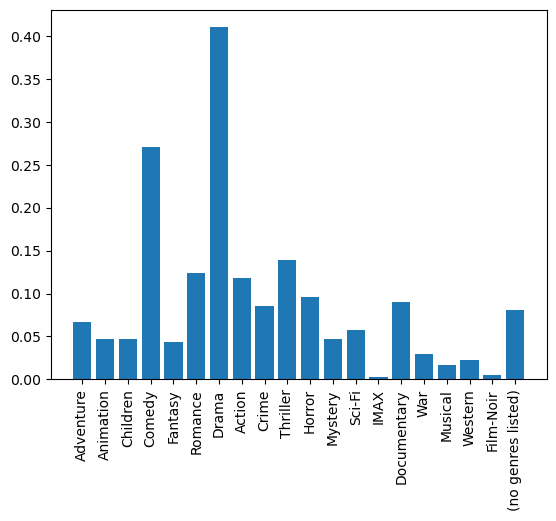

In [4]:
genres = set()
genres_list = []
genres_count = dict()
for i in movies['genres']:
    gen = i.split('|')
    genres_list.append(gen)
    genres = genres.union(set(gen))
    for j in gen:
        if j not in genres_count:
            genres_count[j] = 1
        else:
            genres_count[j] += 1
    
print(f'There are {len(genres)} kinds of genres, they are {genres}')

# convert number to percentage
movies_num = len(movies)
for k,v in genres_count.items():
    genres_count[k] = v/movies_num
plt.bar(*zip(*genres_count.items()))
plt.xticks(rotation=90)
plt.show()

extract the years of movies from the title. If the movies do not contain the year or the year is out of range, we will set it to 'unknow'. The movies are from 1870s to 2010s, a long time span, and the year of movie itself does not affect people like it or not, we will convert it to 'new_movies_ratio', 'old_movies_ratio, which is new_movies/total_movies they watched, the sum of them will be one. Whenever the year of movie is after 2000 will be consider as new movies.

In [5]:
years = []
years_in_decade = {'unkown':0}
nonyear = []
for i in movies['title']:
    year_str = re.findall(r'\(\s*\+?(-?\d+)\s*\)', i)
    if year_str:
        year_int = int(year_str[-1])
    else:
        nonyear.append(i)
        year_int = 0
    if year_int < 1800 or year_int > 2024:
        year_int = 0
        
    years.append(year_int)
    
    deca = year_int//10*10
    if deca == 0:
        years_in_decade['unkown'] += 1
    elif str(deca) not in years_in_decade:
        years_in_decade[str(deca)] = 1
    else:
        years_in_decade[str(deca)] += 1
                
cleaned_movies = pd.DataFrame(columns=['movieId', 'year', 'genres'])
cleaned_movies['movieId'] = movies['movieId']
cleaned_movies['year'] = years
cleaned_movies['genres'] = genres_list

print(cleaned_movies.head())

   movieId  year                                             genres
0        1  1995  [Adventure, Animation, Children, Comedy, Fantasy]
1        2  1995                     [Adventure, Children, Fantasy]
2        3  1995                                  [Comedy, Romance]
3        4  1995                           [Comedy, Drama, Romance]
4        5  1995                                           [Comedy]


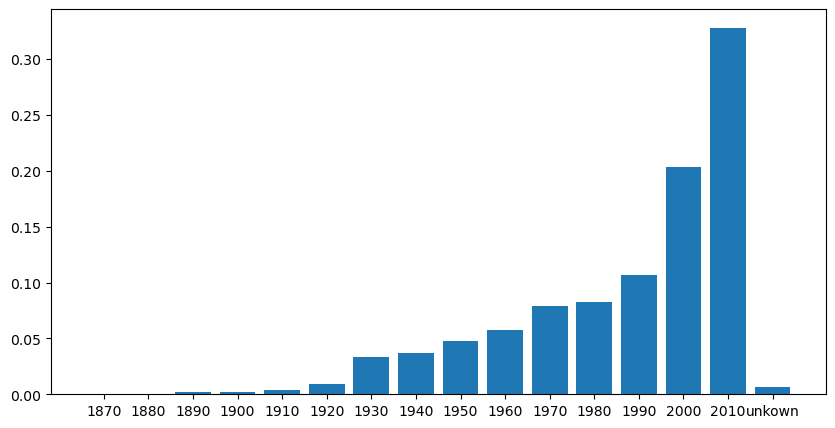

In [6]:
for k,v in years_in_decade.items():
    years_in_decade[k] = v/movies_num

deca = list(years_in_decade.keys())
year_num = list(years_in_decade.values())
deca, year_num = zip(*sorted(zip(deca, year_num)))

fig = plt.figure(figsize = (10, 5))
plt.bar(deca, year_num)
plt.show()

Next step, we will modify the 'ratings' dataset to 'user_preferences'. Calculate the user average rate, how many movies they watch, and which kind of genres they like.

In [7]:
genres_list = list(genres_count.keys())
columns = ['userId', 'number_of_movies', 'average_rate', 'new_movies_rate', 'old_movies_rate']+genres_list
user_preferences = pd.DataFrame(columns=columns)
user_group = ratings.groupby('userId').agg(lambda x: list(x))

movie2index = pd.DataFrame(columns=['movieId', 'df_index'])
movie2index['df_index'] = cleaned_movies.index
movie2index['movieId'] = cleaned_movies['movieId']
movie2index.set_index('movieId', inplace = True)
print(user_group.head())

                                                  movieId  \
userId                                                      
1       [296, 306, 307, 665, 899, 1088, 1175, 1217, 12...   
2       [1, 62, 110, 150, 151, 236, 260, 261, 266, 318...   
3       [1, 29, 32, 50, 111, 172, 173, 214, 260, 293, ...   
4       [1, 260, 296, 541, 589, 780, 924, 1036, 1080, ...   
5       [1, 19, 32, 36, 39, 47, 50, 88, 95, 104, 113, ...   

                                                   rating  \
userId                                                      
1       [5.0, 3.5, 5.0, 5.0, 3.5, 4.0, 3.5, 3.5, 5.0, ...   
2       [3.5, 0.5, 5.0, 4.0, 4.5, 4.0, 5.0, 0.5, 1.0, ...   
3       [4.0, 4.5, 4.5, 5.0, 4.0, 4.0, 3.0, 5.0, 4.0, ...   
4       [3.0, 3.5, 4.0, 4.5, 4.0, 2.0, 4.0, 4.0, 3.5, ...   
5       [4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 3.0, ...   

                                                timestamp  
userId                                                     
1       [1147880044, 114

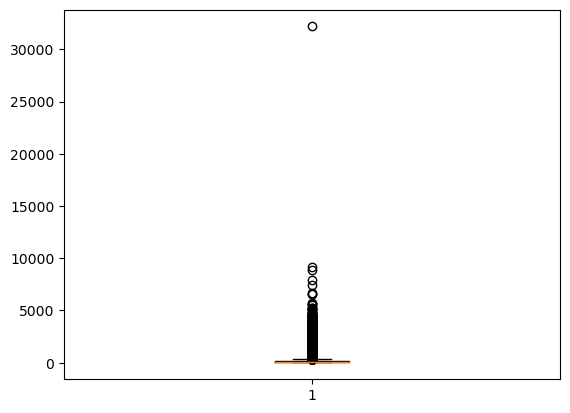

The Min is 20, the Max is 32202


In [8]:
watched_movies = user_group['movieId'].str.len()
plt.boxplot(watched_movies)
plt.show()
print(f'The Min is {min(watched_movies)}, the Max is {max(watched_movies)}')

We can see that there is a extreme outlier and some small outliers in our dataset, and they are very extreme, and will affect our model performence. We need to get rid off them. We will remove what ever is higher than 1000.

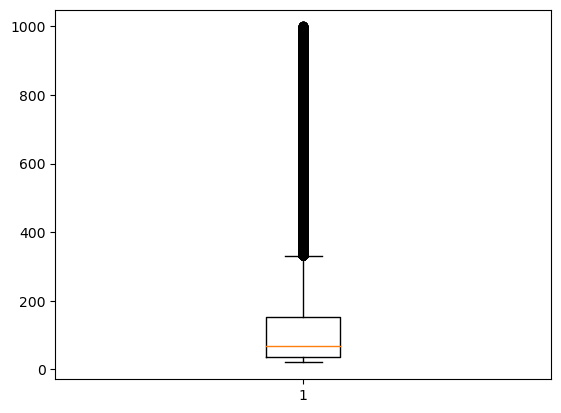

In [9]:
watched_movies_nooutlier = [x for x in watched_movies if x <= 1000]
plt.boxplot(watched_movies_nooutlier)
plt.show()

It looks much better, although it still have a lot of outliters, we will try using it first.


Before we using the cleaned_movies, we want to conver the genres to one hot encoding, list is good for visualization, but is harder for computer to count.

In [10]:
v = cleaned_movies.genres.values
l = [len(x) for x in v.tolist()]
f, u = pd.factorize(np.concatenate(v))
n, m = len(v), u.size
i = np.arange(n).repeat(l)

dummies = pd.DataFrame(
    np.bincount(i * m + f, minlength=n * m).reshape(n, m),
    cleaned_movies.index, u
)
cleaned_movies['new_movies_rate'] = np.where(cleaned_movies['year'] >= 2000 , 1, np.where(cleaned_movies['year'] < 2000, 0,0))
cleaned_movies['old_movies_rate'] = np.where(cleaned_movies['year'] >= 2000 , 0, np.where(cleaned_movies['year'] < 2000, 1,1))
cleaned_movies = cleaned_movies.drop(['genres','year'], axis = 1).join(dummies)


In [37]:
genres_cate = list(genres)

def movieid_to_index(movieid_list):
    return movie2index.loc[movieid_list]
    
def new_row(index):
    # group the movies by user view history
    row = user_group.loc[index]
    # get the movies info by movies id
    movies_info = cleaned_movies.loc[movieid_to_index(row['movieId'])['df_index'].tolist()]
    movies_info = movies_info.drop(['movieId'], axis = 1)
    # weight each row by the rating
    movies_info = movies_info.mul(row['rating'], axis=0)
    non_zero = movies_info.astype(bool).sum(axis=0)
    preferences = movies_info.sum()
    preferences = preferences.divide(non_zero)
    # add other information to the series
    preferences['average_rate'] = np.mean(row['rating'])
    preferences['number_of_movies'] = len(movies_info)
    # we can use either one of the nan filling method, 0 or mean
    #preferences.fillna(0, inplace = True)
    preferences.fillna(preferences['average_rate'], inplace = True)
    preferences['userId'] = int(index)
    return preferences


sub_user = user_group[:8000]
i = 1
for index in sub_user.index:
    if i%800 == 0:
        print(f'finiish {i//80}%')
    i+=1
    user_preferences = pd.concat([user_preferences, new_row(index).to_frame().T], ignore_index=True)
    
print(user_preferences.head())

finiish 10%
finiish 20%
finiish 30%
finiish 40%
finiish 50%
finiish 60%
finiish 70%
finiish 80%
finiish 90%
finiish 100%
   userId  number_of_movies  average_rate  new_movies_rate  old_movies_rate  \
0     1.0              70.0      3.814286         3.803571         3.821429   
1     2.0             184.0      3.630435         3.819672         3.536585   
2     3.0             656.0      3.697409         3.630473         4.147059   
3     4.0             242.0      3.378099         3.308673         3.673913   
4     5.0             101.0      3.752475         3.752475         3.752475   

   Adventure  Animation  Children    Comedy   Fantasy  ...    Horror  \
0   3.727273   4.000000  3.833333  3.869565  3.600000  ...  3.500000   
1   3.906667   3.617647  3.660000  3.317460  3.982759  ...  4.000000   
2   3.689394   3.980000  3.708333  3.454545  3.737179  ...  3.544444   
3   3.074561   3.467742  3.214286  3.611111  2.833333  ...  3.150000   
4   3.857143   3.750000  3.333333  3.571429 

In [38]:
user_preferences.to_csv('cleaned_data_sub.csv', index=False)

### Set up model 
now, we finish cleaning the data, and we are going the set up the model and test the performence. There are 160000+ of users, if using all of them, it will cause the run time to be too long, here we will only use a part of the data, which is 8000 users. But we will use all the movies for testing, it will also test the model how it perform during small trining dataset.

We will compare three models hierarchical clustering, density-based clustering, and k-means

In [34]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
user_preferences = pd.read_csv('cleaned_data_sub.csv')[:8000]

userid2index = pd.DataFrame(columns=['userId', 'df_index'])
userid2index['df_index'] = user_preferences.index
userid2index['userId'] = user_preferences['userId']
userid2index.set_index('userId', inplace = True)

movies_test = cleaned_movies.sample(frac=0.1, random_state=1)
user_test = user_preferences.sample(frac=0.2, random_state=1)
print(f'Number of movies for testing {len(movies_test)}')
print(f'Number of user for testing {len(user_test)}')

Number of movies for testing 6242
Number of user for testing 1600


Because we have 20 genres, we will set our cluster to 20.

In [13]:
train_df = user_preferences.drop(['userId','number_of_movies'], axis = 1)
hierarchical_cluster = AgglomerativeClustering(n_clusters = 20, affinity='euclidean', linkage='ward')
hier_labels = hierarchical_cluster.fit_predict(train_df) 

dens_cluster = DBSCAN(eps=1, min_samples=20)
dens_labels = dens_cluster.fit_predict(train_df)

kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto")
kmean_labels = kmeans.fit_predict(train_df)

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [20]:
print(hier_labels[:10])
print(dens_labels[:10])
print(kmean_labels[:10])

[ 2 12  9 17  5  2 12  9 17  5]
[-1 -1  0 -1 -1 -1 -1  0 -1 -1]
[ 8  8  1 13 12  8  8  1 13 12]


### Evaluation
Because our model is designed to predict new movies, none of the movies in the test set have been rated by anyone. In this way, our model can be deployed on new movie recommendations. We evaluate the model in two ways: 

1. Collaborative-base: randomly choose some users and get their movies list, then compare the score they give with other similar users. We will see how similar with in the group. 

2. Content-base: set a threshold of good movies, and change the problem from rating prediction to binary classification, user will like it or not.

The first method is for old movies, or those a lot of users reted, and it had been use for many compnaies like eBay, Amazon, Youtube.

The second evaluation is situable for new movies, because we only care about whether we can recommend movies that the audience is interested in, and we don't care about the scores users give to movies, and the movies they do not like.

Since only KMeans have the predict funtion, and DBSCAN, AgglomerativeClustering can only clustering, we will test mainly evaluatie the model in collaborative-base.

In [115]:
def eva(labels, user_test):
    id_and_groups = pd.DataFrame(columns=['userId'])
    id_and_groups['userId'] = user_preferences['userId']
    id_and_groups['cluster'] = labels
    scoring_matrix = pd.merge(ratings[:1300000], id_and_groups, on ='userId')
    id_and_groups.set_index('userId', inplace = True)
    aver_sum = 0
    for en, i in enumerate(user_test['userId']):
        clus = labels[en]
        movieid = user_group.loc[i]['movieId'][0]
        m = scoring_matrix.loc[(scoring_matrix['cluster'] == int(clus)) & (scoring_matrix['movieId'] == movieid)]
        aver = m['rating'].mean() - scoring_matrix.loc[(scoring_matrix['userId'] == i) & (scoring_matrix['movieId'] == movieid)]['rating']
        aver_sum += np.abs(float(aver.sum()))
    return aver_sum/len(user_test)

print(f'The error of hiehierarchical clustering is {eva(hier_labels, user_test)}')
print(f'The error of DBSCAN is {eva(dens_labels, user_test)}')
print(f'The error of K-means is {eva(kmean_labels, user_test)}')

The error of hiehierarchical clustering is 0.8695065413796967
The error of DBSCAN is 0.7764615503229109
The error of K-means is 0.8753032321423114


### Tuning model
Now we will tune our model find the best hyperparameters. We can change the n_clusters and affinity.

In [121]:
# we will grid search the DBSCAN and AgglomerativeClustering
eps = [0.1,0.3,0.6,1,1.3]
for i in eps:
    print(f'DBSCAN with eps {i} in error {eva(DBSCAN(eps=i, min_samples=20).fit_predict(train_df), user_test)}')


DBSCAN with eps 0.1 in error 0.7724272367254863
DBSCAN with eps 0.3 in error 0.7724272367254863
DBSCAN with eps 0.6 in error 0.7731122718195839
DBSCAN with eps 1 in error 0.7764615503229109
DBSCAN with eps 1.3 in error 0.7792071239585294


In [120]:
n_clu = [14,16,18,20,22]
for i in n_clu:
    err = eva(AgglomerativeClustering(n_clusters = i, linkage='ward').fit_predict(train_df) ,user_test)
    print(f'AgglomerativeClustering with n_cluster {i} in error {err}')


AgglomerativeClustering with n_cluster 14 in error 0.8614336273220782
AgglomerativeClustering with n_cluster 16 in error 0.8647884032747148
AgglomerativeClustering with n_cluster 18 in error 0.8672001376989245
AgglomerativeClustering with n_cluster 20 in error 0.8695065413796967
AgglomerativeClustering with n_cluster 22 in error 0.8709576653434854


### Conclusion
This project is mainly focusing on cleaning and modifing the data, so we don't need to use complex model or do much model tuning. Our models give good performance, and DBSCAN have the best result.  

### Discussion
Future work: Further improve the recommendation system based on this model. When recommending, focus on recommending to potentially interested users, but also randomly recommend to other users, because there is a chance that other users will be interested. We can recommend some of them first, and decide whether to recommend others according to the ratings of the first group of viewers. Here we can add a supervised learning model, which is more accurate. Changing 'unsupervised learning' into 'self-supervised learning'.